In [1]:
import torch # type: ignore
import torchvision # type: ignore
from typing import Tuple, Dict, List
from pathlib import Path 
from zipfile import ZipFile
from PIL import Image # type: ignore
from torch.utils.data import Dataset # type: ignore
from torchvision import transforms # type: ignore
import os

torch.__version__

'2.4.0'

In [2]:
DIR_PATH = Path("data")
IMAGE_PATH = DIR_PATH / "spoiled-fresh"

if IMAGE_PATH.is_dir():
    print("data already exist!")
else: 
    print("extracting data..")
    with ZipFile(file=DIR_PATH / "spoiled-fresh.zip", mode="r") as zip_ref:
        zip_ref.extractall(IMAGE_PATH)
    os.remove(DIR_PATH / "spoiled-fresh.zip")
    print("[INFO] done unzipping the file")

data already exist!


In [3]:
type(IMAGE_PATH)

pathlib.WindowsPath

In [4]:
IMAGE_PATH = DIR_PATH / "spoiled-fresh" / "FRUIT-16K"
sorted(entry.name for entry in os.scandir(IMAGE_PATH))

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [5]:
# create custom dataset
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory 
    """
    # 1. get the class names by scanning the target directory 
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. raise an error is class names couldn't be found 
    if not classes:
        raise FileNotFoundError(f"couldn't find any classes in {directory}")
    
    # 3. create a dictionary of index labels 
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [6]:
classes, class_to_idx = find_classes(directory=IMAGE_PATH)
class_to_idx

{'F_Banana': 0,
 'F_Lemon': 1,
 'F_Lulo': 2,
 'F_Mango': 3,
 'F_Orange': 4,
 'F_Strawberry': 5,
 'F_Tamarillo': 6,
 'F_Tomato': 7,
 'S_Banana': 8,
 'S_Lemon': 9,
 'S_Lulo': 10,
 'S_Mango': 11,
 'S_Orange': 12,
 'S_Strawberry': 13,
 'S_Tamarillo': 14,
 'S_Tomato': 15}

In [7]:
IMAGE_PATH / classes[0]

WindowsPath('data/spoiled-fresh/FRUIT-16K/F_Banana')

In [8]:
# 1. catch all the folder classes as iterables 
len(list(Path(IMAGE_PATH / classes[0]).glob("*.jpg")))

1000

In [9]:
a = [1, 2, 3]
a.extend([4, 5, 6])
a

[1, 2, 3, 4, 5, 6]

In [10]:
# write a custom dataset class 

# 1. subclass torch.utils.data.Dataset 
class ImageFolderCustom(Dataset):
    # 2. initialize the constructor
    def __init__(self, targ_dir: str, heads: list[str], transform=None, is_training: bool = True):
        # 3. create several attributes 
        # get all the image paths
        self.training = []
        self.testing = []
        for tag in heads: 
            self.img_list = list(Path(targ_dir / tag).glob("*.jpg"))
            self.train_length = int(len(self.img_list) * 0.8)
            self.training.extend(self.img_list[:self.train_length])
            self.testing.extend(self.img_list[self.train_length:])

        if is_training: 
            self.paths = self.training
        else: 
            self.paths = self.testing
        # setup transforms
        self.transform = transform
        # create classes and class_to_idx 
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. create a function to load images 
    def load_image(self, index: int) -> Image.Image: 
        "opens an image via a path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. overwrite __len__()
    def __len__(self) -> int: 
        return len(self.paths)
    
    # 6. overwrite __getitem__() to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "returns one sample of data, data and the label (X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary 
        if self.transform:
            return self.transform(img), class_idx
        else: 
            return img, class_idx

In [11]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])

In [12]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), 
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), 
    transforms.ToTensor(), 
    normalize
])

In [13]:
# test out ImageFolderCustom()
train_data_custom = ImageFolderCustom(targ_dir=IMAGE_PATH, heads=classes, 
                                        transform=train_transform, is_training=True)

test_data_custom = ImageFolderCustom(targ_dir=IMAGE_PATH, heads=classes,
                                        transform=test_transform, is_training=False)

In [14]:
type(IMAGE_PATH)

pathlib.WindowsPath

In [15]:
from data_setup import create_dataloaders

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(image_dir=IMAGE_PATH, heads=classes, train_transform=train_transform, test_transform=test_transform, batch_size=BATCH_SIZE, num_workers=0)

In [16]:
len(train_dataloader), len(test_dataloader), class_names

(400,
 100,
 ['F_Banana',
  'F_Lemon',
  'F_Lulo',
  'F_Mango',
  'F_Orange',
  'F_Strawberry',
  'F_Tamarillo',
  'F_Tomato',
  'S_Banana',
  'S_Lemon',
  'S_Lulo',
  'S_Mango',
  'S_Orange',
  'S_Strawberry',
  'S_Tamarillo',
  'S_Tomato'])

## experiments

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
# setup hyperparameters
models = ["effnetb0", "effnetb2"]
num_epochs = [5]
train_dataloaders = {"freshvisionv0": train_dataloader}

In [19]:
# from experiments import run_experiment as rex 

# rex(train_dataloaders=train_dataloaders, test_dataloader=test_dataloader, num_epochs=num_epochs, models=models, class_names=class_names, device=device)

In [20]:
import model_builder as mb 

model_0 = mb.create_model_baseline_effnetb0(out_feats=len(class_names), device=device)
model_1 = mb.create_model_baseline_effnetb2(out_feats=len(class_names), device=device)

[INFO] created a model effnetb0
[INFO] created a model effnetb2


In [61]:
model_0.load_state_dict(torch.load(f="models/effnetb0_fruitsvegs0_5_epochs.pt"))
model_1.load_state_dict(torch.load(f="models/effnetb2_fruitsvegs0_5_epochs.pt"))

C:\Users\bolth\AppData\Local\Temp\ipykernel_3844\2072356152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0.load_state_dict(torch.load(f="models/effnetb0_fruitsv

<All keys matched successfully>

In [23]:
training_dir = []
testing_dir = []
for tag in classes: 
    img_list = list(Path(IMAGE_PATH / tag).glob("*.jpg"))
    train_length = int(len(img_list) * 0.8)
    training_dir.extend(img_list[:train_length])
    testing_dir.extend(img_list[train_length:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data\spoiled-fresh\FRUIT-16K\F_Lemon\819.jpg


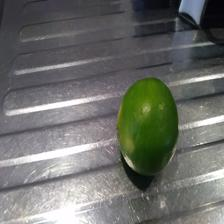

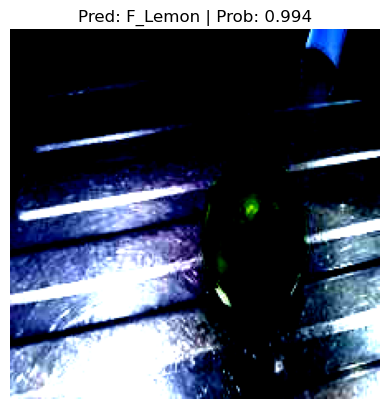

In [41]:
from utils import pred_and_plot_image

pred_and_plot_image(model=model_0, image_path=testing_dir[900], class_names=classes, transform=test_transform, device=device)
print(testing_dir[900])

Image.open(testing_dir[900])

In [53]:
import matplotlib.pyplot as plt # type: ignore
from PIL import Image # type: ignore
import requests # type: ignore

def pred_and_plot(model: torch.nn.Module, 
                    image_path: str,
                    transform: transforms.Compose,
                    class_names: list[str] = None):
        model = model.to(device)
        # load image
        img = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
        # setup transformed image 
        transformed_img = transform(img).to(device)
        # forward pass 
        logits = model(transformed_img.unsqueeze(dim=0))
        pred = torch.softmax(logits, dim=-1).argmax(dim=-1)
        # plot the image along with the label 
        plt.imshow(transformed_img.permute(1, 2, 0).cpu())
        title = f"{class_names[pred]} | {torch.softmax(logits, dim=-1).max():.3f}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


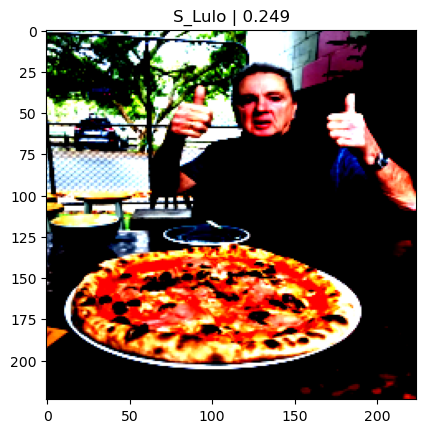

In [74]:
pred_and_plot(model=model_0, image_path="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg", 
                transform=test_transform, class_names=classes)